In [1]:
import os
from typing import Callable

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

from quick_downloader import QuickDownloader
from chrome_utils import GrafanaUrlInputs
from processor.load import load_sum_total, load_mean_df
from processor.filters import cut_by_window
import pandas as pd
import numpy as np
import seaborn as sns

import matplotx  # Assuming matplotx is installed

from utils import load_df_with_time_index

In [2]:
def get_os_and_processor(name: str) -> tuple[str, str]:
    os_ = "Windows" if "perfw" in name.lower() else "Linux"
    processor = "AMD" if "amd" in name.lower() else "Intel"
    return os_, processor

In [3]:
def plot_hist(
        x_col: str,
        df: pd.DataFrame,
        unit: str,
        ylabel: str,
        title: str,
        ax: plt.Axes | None = None,
        legend_loc: str = "upper left"
):
    instances = df["instance"].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

    plt.rcParams["text.usetex"] = True

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 2.5))

    sns.histplot(df.reset_index(), x=x_col, hue="instance", kde=True, palette=palette, ax=ax, multiple="layer")

    line_handles = []
    data = {}
    for name, group in df.groupby("instance"):
        mean = group[x_col].mean()
        ax.axvline(mean, color=palette[name], linestyle="-")
        line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle="-", label=rf"$\bar{{x}}$"))
        std = group[x_col].std()

        p25 = np.percentile(group[x_col], 25)
        p75 = np.percentile(group[x_col], 75)
        ax.axvline(p25, color=palette[name], linestyle=":")
        ax.axvline(p75, color=palette[name], linestyle=":")

        line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle=":", label="25th/75th pct"))

        data[name] = {"mean": mean, "std": std}

    hist_handles = [
        mlines.Line2D(
            [], [], color=palette[name], marker='s', linestyle='',
            label=rf"{name} $\bar{{x}}$={data[name]['mean']:0.2f} [{unit}] $\sigma$={data[name]['std']:0.2f} [{unit}]"
        )
        for name in instances
    ]

    hist_handles.extend(line_handles)
    legend1 = ax.legend(handles=hist_handles, title="", loc=legend_loc)
    ax.add_artist(legend1)

    plt.title(title)
    plt.xlabel(unit)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()


def plot_over_time(df: pd.DataFrame, y_col: str, title: str, ylabel: str, grouper: str = "instance",
                   ax: plt.Axes | None = None):

    instances = df[grouper].unique()
    print(instances)
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))
    for name, group in df.groupby(grouper):
        color = palette.get(name)
        group.plot(use_index=True, y=y_col, label=name, ax=ax, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()


def plot_bar(df: pd.DataFrame, x_col: str, y_col: str, title: str, ylabel: str, grouper: str = "instance",
             errorbar: str = "sd",
             legend: bool = True,
             show_numbers: bool = True,
             ax: plt.Axes | None = None, estimator="max", fmt="%.0f"):
    instances = df[grouper].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))

    sns.barplot(
        data=df.reset_index(),
        x=x_col, y=y_col, hue=grouper,
        ax=ax, palette=palette, errorbar=errorbar, legend=legend, estimator=estimator
    )
    if show_numbers:
        for container in ax.containers:
            ax.bar_label(container, fmt=fmt)

    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()


def plot_cat_bar(
        df: pd.DataFrame,
        y_col: str,
        axis_labels: tuple[str, str],
        title: str,
        x_col: str = "processor",
        hue_col: str = "os",
        row_col: str = "vus",
        errorbar: str = "sd",
        palette: dict = None,
):
    instances = df[hue_col].unique()
    if palette is None:
        palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
    g = sns.catplot(
        data=df.reset_index(), kind="bar",
        x=x_col, y=y_col, hue=hue_col, row=row_col,
        errorbar=errorbar, palette=palette
    )
    g.despine(left=True)
    g.set_axis_labels(*axis_labels)
    plt.title(title)
    plt.show()
    return g

def plot_grouped_means_with_palette(
        df: pd.DataFrame,
        value_col: str,
        ax: plt.Axes,
        group_col: str = "instance",
        palette_name: str = "tab10",
        line_style: str = "--",
        label_fmt: str = r"$\bar{{x}}$={mean:.2f}s $\sigma$={std:.2f}s"
):
    instances = df[group_col].unique()
    palette = dict(zip(instances, sns.color_palette(palette_name, len(instances))))
    for name, group in df.groupby(group_col):
        mean_value = group[value_col].mean()
        std_value = group[value_col].std()
        ax.axhline(
            mean_value,
            color=palette[name],
            linestyle=line_style,
            label=label_fmt.format(mean=mean_value, std=std_value)
        )

def save_plot_if_new(filename: str, dpi: int = 300, style: str = matplotx.styles.dracula, force: bool = False, show_labels: bool = True):
    """
    Save the current matplotlib figure to `filename` only if it does not exist.
    """
    if force and os.path.exists(filename):
        os.remove(filename)

    if show_labels:
        plt.xlabel()
        plt.ylabel()

    if not os.path.exists(filename):
        if style:
            with plt.style.context(style):
                plt.savefig(filename, dpi=dpi, transparent=True)
        else:
            plt.savefig(filename, dpi=dpi, transparent=True)
        print(f"Plot saved to {filename}")

In [4]:
import pickle as pkl
data_ = pkl.load(open("results/quick_data.pkl", "rb"))

In [5]:
data_["perflamd1_l1"]["dashboards"]["cpu"] = "./quick/linux cpu.csv"
data_["perfwamd2_l2"]["dashboards"]["cpu"] = "./quick/windows cpu.csv"
data_["perflamd1_l1"]["dashboards"]["memory"] = "./quick/linux memory.csv"
data_["perfwamd2_l2"]["dashboards"]["memory"] = "./quick/windows memory.csv"

In [6]:
data_

defaultdict(dict,
            {'perflamd1_l1': {'tables': {'Iterations per Scenario': './quick/perflamd1_2025-08-21_13-36-30-Iterations per Scenario_table.csv',
               'Request Duration per Scenario p99': './quick/perflamd1_2025-08-21_13-36-30-Request Duration per Scenario p99_table.csv',
               'Avg Iteration Duration p99': './quick/perflamd1_2025-08-21_13-36-30-Avg Iteration Duration p99_table.csv',
               'TTFB per Scenario': './quick/perflamd1_2025-08-21_13-36-30-TTFB per Scenario_table.csv',
               'Total Requests per Scenario': './quick/perflamd1_2025-08-21_13-36-30-Total Requests per Scenario_table.csv'},
              'dashboards': {'Total Requests per Scenario': './quick/perflamd1_2025-08-21_13-36-30-Total Requests per Scenario.csv',
               'Iterations per Scenario': './quick/perflamd1_2025-08-21_13-36-30-Iterations per Scenario.csv',
               'TTFB per Scenario': './quick/perflamd1_2025-08-21_13-36-30-TTFB per Scenario.csv',
     

In [7]:
def merge_grouped_dashboards(stored_data: dict[str, dict], dashboard_name: str, loader: Callable[[str], pd.DataFrame]):
    dfs = []
    for data in stored_data.values():
        vus = data["vus"]
        test_instance, identifier = data["instance_identifier"]
        dashboards = data["dashboards"]
        df = loader(dashboards[dashboard_name])
        df = df.melt(var_name='meta', value_name='value', ignore_index=False)
        df["value"] = pd.to_numeric(df["value"].str.replace("%", ""), errors="coerce")
        df["vus"] = vus
        df["instance"] = "{} {}".format(*get_os_and_processor(test_instance))
        df["identifier"] = identifier
        df["os"], df["processor"] = get_os_and_processor(test_instance)
        # Apply extract_fields to the 'meta' column
        dfs.append(df)

    merged = pd.concat(dfs)
    merged = merged.sort_index()
    merged = merged.reset_index().set_index("Time")

    return merged

to_keep = ["erp-6f4597d5c4-24n5g", "erp-78b8b7587f-zbpck"]
cpu = merge_grouped_dashboards(data_, "cpu", load_df_with_time_index)
memory = merge_grouped_dashboards(data_, "memory", load_df_with_time_index)
cpu = cut_by_window(cpu[cpu["meta"].isin(to_keep)], "20m","40m").dropna()
memory = cut_by_window(memory[memory["meta"].isin(to_keep)], "20m","40m").dropna()

In [8]:
cpu.groupby("instance")["value"].describe()

,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
Linux AMD,41.0,27.415854,1.120605,25.27,26.79,27.31,28.09,30.56
Windows AMD,39.0,18.377179,2.129078,15.87,17.15,17.57,18.40,24.24


In [9]:
memory.groupby("instance")["value"].describe()

,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
Linux AMD,41.0,21.379512,0.823064,19.07,20.910,21.65,22.000,22.39
Windows AMD,39.0,19.040000,3.332124,16.75,17.545,18.13,18.595,33.29


## Memory Usage Percentage

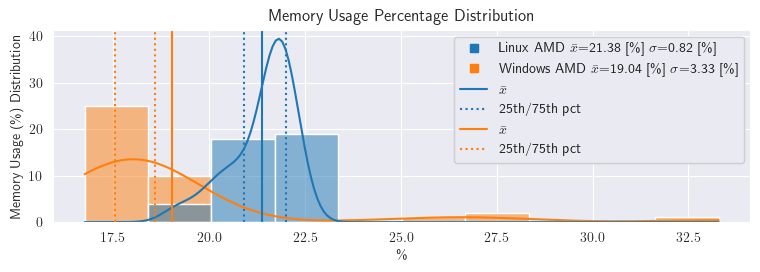

In [10]:
plot_hist(
    x_col="value",
    df=memory,
    unit=r"\%",
    ylabel=r"Memory Usage (\%) Distribution",
    title="Memory Usage Percentage Distribution",
legend_loc="upper right")
save_plot_if_new("results/Memory Usage Percentage Distribution.png", dpi=300)
plt.show()

['Linux AMD' 'Windows AMD']


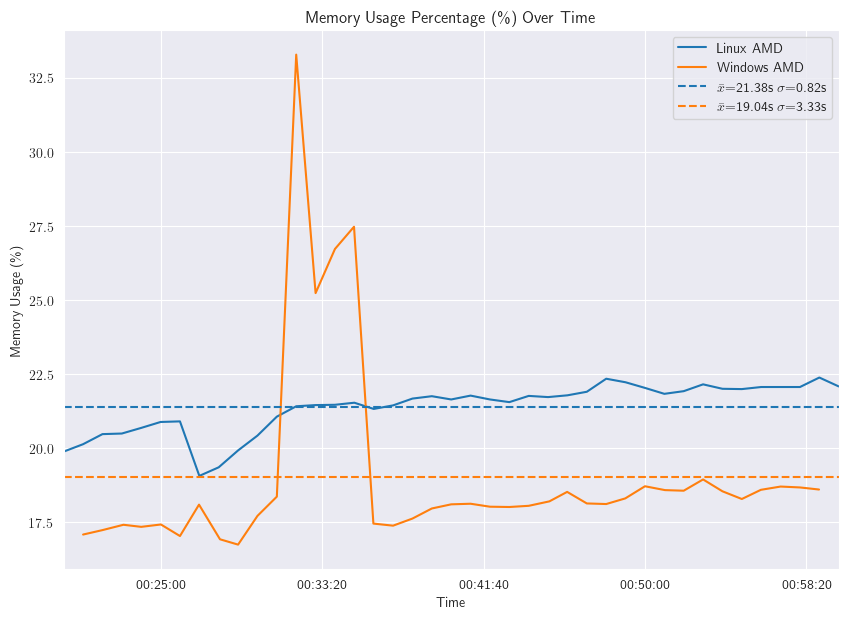

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

plot_over_time(memory, y_col="value", title=r"Memory Usage Percentage (\%) Over Time", ylabel=r"Memory Usage (\%)", ax=ax)
plot_grouped_means_with_palette(memory, "value", ax)
plt.legend()
save_plot_if_new("results/Memory Usage Percentage Over Time.png", dpi=300)
plt.show()

## CPU Usage Percentage

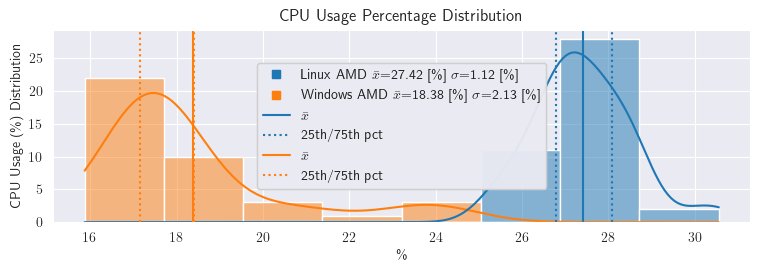

In [12]:
plot_hist(
    x_col="value",
    df=cpu,
    unit=r"\%",
    ylabel=r"CPU Usage (\%) Distribution",
    title="CPU Usage Percentage Distribution",
    legend_loc="center"
)
save_plot_if_new("results/CPU Usage Percentage Distribution.png", dpi=300)
plt.show()

['Linux AMD' 'Windows AMD']


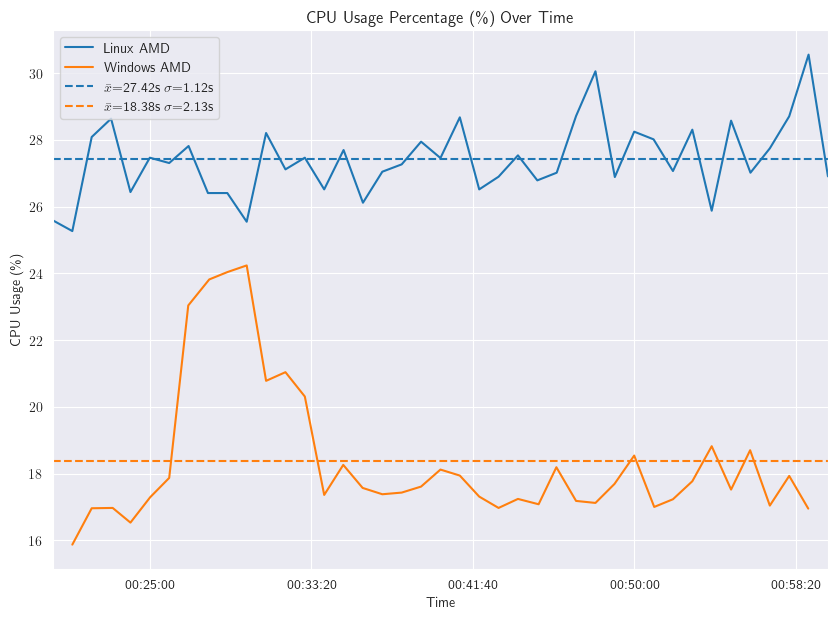

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
plot_over_time(cpu, y_col="value", title=r"CPU Usage Percentage (\%) Over Time", ylabel=r"CPU Usage (\%)", ax=ax)
plot_grouped_means_with_palette(cpu, "value", ax)
plt.legend()
save_plot_if_new("results/CPU Usage Percentage Over Time.png", dpi=300)
plt.show()